In [1]:
"""
Analyze GRASP for each detector design
author: Jiancheng Zeng
Date: May 1, 2023
"""

'\nAnalyze GRASP for each detector design\nauthor: Jiancheng Zeng\nDate: May 1, 2023\n'

In [2]:
"""
RUN THIS BLOCK before others!
You don't need to change anything in this code block unless you want to define your own changes.
This block is for defining functions that will be used for analysis
"""

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt

# this function calculate distance in 3D space
def calculate_distance(x1, y1, z1, x2, y2, z2):
    distance = math.hypot(math.hypot(x2 - x1, y2 - y1), z2 - z1)
    return distance


# This function reads toy model data and reconstruct it in a more user friendly format. 
# After this, each event will have their own data structire
# If you want to all the event ID from the 12th event, you could do:
# 
# data = read_data_from_toymodel(file_path)
# list(data.keys())[12]
# 
# If you want to call all the dataa from the 12th event, you could do:
# 
# data[list(data.keys())[12]]
# 
def read_data_from_toymodel(file_path):
    print("Reading data...\n")
    try:
        df = pd.read_csv(file_path, delimiter='\t')  # Assumes tab-separated values in the text file

        # Name each data group with event ID
        grouped = df.groupby(df.iloc[:, 0])

        # Create an empty dictionary to store the 3D data structure
        data_3d = {}

        # Iterate over each group and populate the dictionary
        for group_name, group_data in grouped:
            data_3d[group_name] = group_data.values
        
        print("Toy Model data imported\nFound " + str(len(list(data_3d.keys()))) + " Events!")
        
        # Clear the data buffer
        df = None
        
        return data_3d
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse data from '{file_path}'. Please ensure the file has the correct format.")
        return None


# This function doing GRASP analysis
def Analyze_GRASP(data_3d, particle_ID, stop_event=False, in_flight_event=False):
    
    # This is the event number in the raw data
    Event_list = list(data_3d.keys())
    
    # Construct a empty vector for initial energy store
    Init_Energy = []
    
    # Counting the number of stop events
    N_stop_event = 0
    
    
    for i in range(len(Event_list)):
        # general condition that all the events has to match, here shows the last point is inside Liquid Argon
        condition = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 6] == 'LAr' 
        # conditions for stop events, here shows last point has 0 energy left and 0 energy deposit
        condition_stop = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        # conditions for in flight annihilation events, here shows last point has energy larger than 0
        condition_in_flight = np.min(data_3d[Event_list[i]][:, 8]) != 0 and in_flight_event
        
        if(condition_stop or condition_in_flight and condition):
            N_stop_event = N_stop_event + 1
            Init_Energy.append(data_3d[Event_list[i]][0, 8])
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    print("\n We got " + str(N_stop_event) + " events selected")
    print("Last event is "+ str(Event_list[len(Event_list)-1]))
    
    # return two things, first one is the inital energy array and second one is the number of the event generated.
    return np.array(Init_Energy), Event_list[len(Event_list)-1]


# This function analyze distance traveled inside LAr
def Analyze_trace(data_3d, particle_ID, stop_event=False, in_flight_event=False):
    
    # This is the event number in the raw data
    Event_list = list(data_3d.keys())
    
    # Construct a empty vector for initial energy store
    Init_Energy = []
    
    # record the depth that primary particle traveled inside LAr
    Depth = []
    
    # record the distance that primary particle traveled inside LAr
    Distance = []
    
    for i in range(len(Event_list)):
        # general condition that all the events has to match, here shows the last point is inside Liquid Argon
        condition = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 6] == 'LAr' 
        # conditions for stop events, here shows last point has 0 energy left and 0 energy deposit
        condition_stop = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        # conditions for in flight annihilation events, here shows last point has energy larger than 0
        condition_in_flight = np.min(data_3d[Event_list[i]][:, 8]) != 0 and in_flight_event
        
        if(condition_stop or condition_in_flight and condition):
            x1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 16]
            y1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 17]
            z1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 18]
            minimum_time = np.min(data_3d[Event_list[i]][data_3d[Event_list[i]][:, 6] == 'LAr'][:, 7])
            x2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 16]
            y2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 17]
            z2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 18]
            #print(minimum_time)
            Distance.append(calculate_distance(x1, y1, z1, x2, y2, z2))
            Depth.append(z2-z1)
            Init_Energy.append(data_3d[Event_list[i]][0, 8])
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    print("\n We got " + str(len(Depth)) + " events selected")
    print("Last event is "+ str(Event_list[len(Event_list)-1]))
    
    # return two things, first one is the inital energy array and second one is the depth traveled inside LAr.
    return np.array(Init_Energy), np.array(Depth), np.array(Distance)


# This function is for analyzing TOF and angle of the trace
# Need update!
def Analyze_TOF(data_3d, particle_ID, stop_event=False):
    Event_list = list(data_3d.keys())
    TOF_out_E = []
    TOF_in_E = []
    for i in range(len(Event_list)):
        Energy_out = 0
        Energy_in = 0
        for j in range(len(data_3d[Event_list[i]])):
            if(str(data_3d[Event_list[i]][j, 5]) == '-10000' or str(data_3d[Event_list[i]][j, 5]) == '-10001' or str(data_3d[Event_list[i]][j, 5]) == '-10002' or str(data_3d[Event_list[i]][j, 5]) == '-10003' or str(data_3d[Event_list[i]][j, 5]) == '-10004' or str(data_3d[Event_list[i]][j, 5]) == '-10005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_out = Energy_out + float(data_3d[Event_list[i]][j, 9])
                #print(Energy_out)
                #if str(data_3d[Event_list[i]][j+1, 5]) != str(data_3d[Event_list[i]][j, 5]):
                    #break
            if(str(data_3d[Event_list[i]][j, 5]) == '-11000' or str(data_3d[Event_list[i]][j, 5]) == '-11001' or str(data_3d[Event_list[i]][j, 5]) == '-11002' or str(data_3d[Event_list[i]][j, 5]) == '-11003' or str(data_3d[Event_list[i]][j, 5]) == '-11004' or str(data_3d[Event_list[i]][j, 5]) == '-11005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_in = Energy_in + float(data_3d[Event_list[i]][j, 9])
        if(stop_event==True):
            condition = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        else:
            condition = True

        if(Energy_in != 0 and Energy_out != 0 and condition):
            TOF_out_E.append(Energy_out)
            TOF_in_E.append(Energy_in)
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    Result_Vector = np.array([TOF_out_E, TOF_in_E])
    print("\n")
    print("number of events is:"+str(Event_list[len(Event_list)-1]))
    return Result_Vector, Event_list[len(Event_list)-1]


# This function is for plotting the histgram of GRASP
def GRASP_hist(GRASP_vector, particle_ID, label, total_event, energy_min, energy_max, num_bins, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    GRASP_bin = []
    
    Xaxis = np.linspace(energy_min, energy_max, num_bins + 1) / number_of_nucleons(particle_ID)[1]
    centersXaxis = Xaxis[:-1] + np.diff(Xaxis) / 2

    for i in range(num_bins):
        bin_start = i * ((energy_max - energy_min) / num_bins)
        bin_end = (i + 1) * ((energy_max - energy_min) / num_bins)
        GRASP_bin.append(400 * math.pi * len(GRASP_vector[(GRASP_vector > bin_start) & (GRASP_vector < bin_end)]) / (total_event / num_bins))
        
        # For debugging each bin
        # print("GRASP_bin[" + str(i) + "] is " + str(GRASP_bin[i]))
        
    ax.step(centersXaxis, GRASP_bin, where='mid', label=str(label)+"("+str(len(GRASP_vector))+" events)", alpha=0.8)
    ax.set_xlabel("energy [MeV/n]")
    ax.set_ylabel("GRASP [m^2 sr]")
    ax.legend()
    ax.grid(alpha=0.2)
    ax.set_title('GRASP (Geometric Acceptance)')
    return ax


#This function is for identify particles in geant4 including particle ID and Z numbers etc
def number_of_nucleons(particle_ID):
    data = [[2212, 1000010020, 1000020030, -2212, -1000010020, -1000020030],
            [1, 2, 3, 1, 2, 3]]
    df = pd.DataFrame(data, columns=['proton', 'deuteron', 'helium3', 'antiproton', 'antideuteron', 'antihelium3'])
    matching_columns = df.columns[df.eq(particle_ID).any()]
    particle_info = df[matching_columns[0]]
    return particle_info


Reading data...

Toy Model data imported
Found 10539 Events!
Now processing (10538/10539)
 We got 2108 events selected
Last event is 9999140
Reading data...

Toy Model data imported
Found 10357 Events!
Now processing (10356/10357)
 We got 1981 events selected
Last event is 9999811
Reading data...

Toy Model data imported
Found 10211 Events!
Now processing (10210/10211)
 We got 2030 events selected
Last event is 9997221
Reading data...

Toy Model data imported
Found 10739 Events!
Now processing (10738/10739)
 We got 2127 events selected
Last event is 9998705
Reading data...

Toy Model data imported
Found 10883 Events!
Now processing (10882/10883)
 We got 2148 events selected
Last event is 9999384
Reading data...

Toy Model data imported
Found 11399 Events!
Now processing (11398/11399)
 We got 2236 events selected
Last event is 9998845
Reading data...

Toy Model data imported
Found 12523 Events!
Now processing (12522/12523)
 We got 2560 events selected
Last event is 9999316
Reading data.

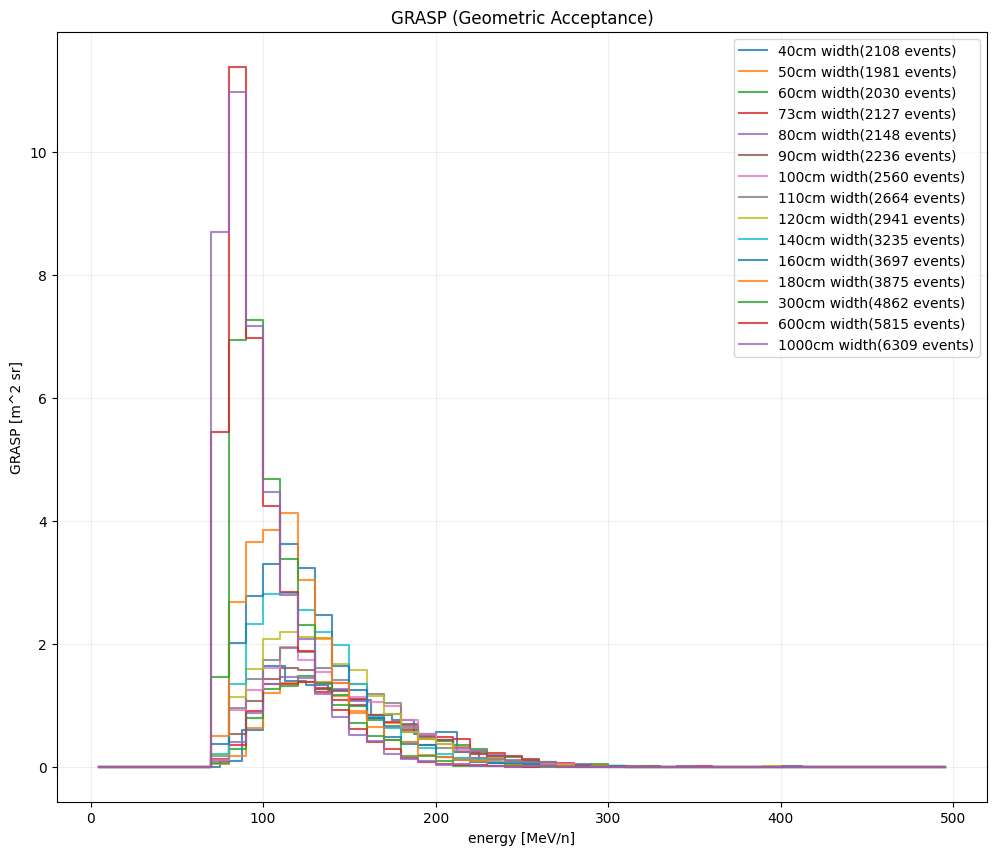

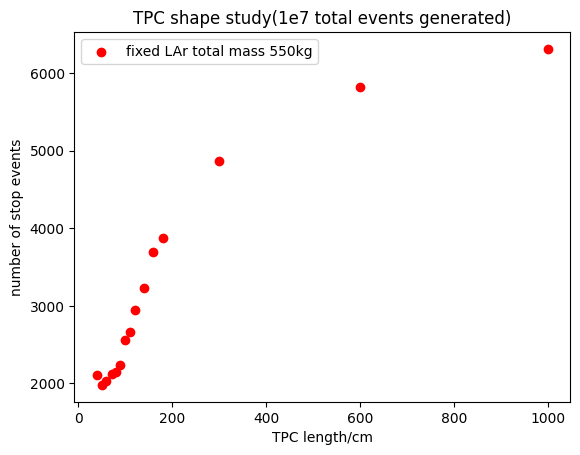

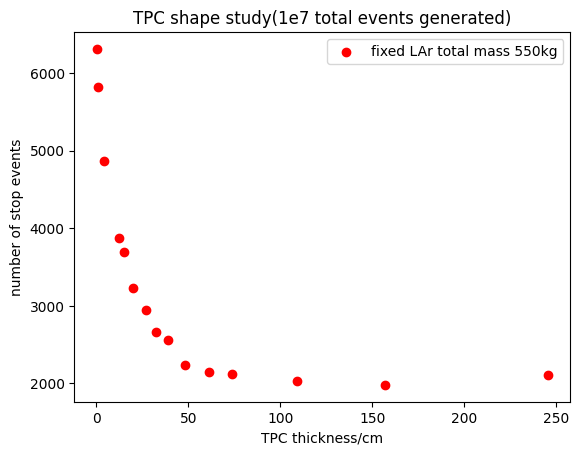

In [3]:
fig, ax = plt.subplots(figsize=(12, 10))

Stop_Events = []
TPC_length = []

plt.figure(1)

file_path_atmo_1e7_40 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_40cm.dat'
label_40cm= '40cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_40 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_40), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_40[0]))
TPC_length.append(40)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_40 = GRASP_hist(GRASP_1e7_40[0], -1000010020, label_40cm, GRASP_1e7_40[1], 0, 1000, 40, ax=ax)
GRASP_1e7_40 = None

file_path_atmo_1e7_50 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm.dat'
label_50cm= '50cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_50 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_50), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_50[0]))
TPC_length.append(50)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_50 = GRASP_hist(GRASP_1e7_50[0], -1000010020, label_50cm, GRASP_1e7_50[1], 0, 1000, 50, ax=ax)
GRASP_1e7_50 = None

file_path_atmo_1e7_60 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_60cm.dat'
label_60cm= '60cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_60 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_60), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_60[0]))
TPC_length.append(60)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_60 = GRASP_hist(GRASP_1e7_60[0], -1000010020, label_60cm, GRASP_1e7_60[1], 0, 1000, 50, ax=ax)
GRASP_1e7_60 = None

file_path_atmo_1e7_73 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_73cm.dat'
label_73cm= '73cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_73 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_73), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_73[0]))
TPC_length.append(73)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_73 = GRASP_hist(GRASP_1e7_73[0], -1000010020, label_73cm, GRASP_1e7_73[1], 0, 1000, 50, ax=ax)
GRASP_1e7_73 = None

file_path_atmo_1e7_80 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_80cm.dat'
label_80cm= '80cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_80 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_80), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_80[0]))
TPC_length.append(80)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_80 = GRASP_hist(GRASP_1e7_80[0], -1000010020, label_80cm, GRASP_1e7_80[1], 0, 1000, 50, ax=ax)
GRASP_1e7_80 = None

file_path_atmo_1e7_90 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_90cm.dat'
label_90cm= '90cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_90 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_90), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_90[0]))
TPC_length.append(90)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_90 = GRASP_hist(GRASP_1e7_90[0], -1000010020, label_90cm, GRASP_1e7_90[1], 0, 1000, 50, ax=ax)
GRASP_1e7_90 = None

file_path_atmo_1e7_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_100cm.dat'
label_100cm= '100cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_100 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_100), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_100[0]))
TPC_length.append(100)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_100 = GRASP_hist(GRASP_1e7_100[0], -1000010020, label_100cm, GRASP_1e7_100[1], 0, 1000, 50, ax=ax)
GRASP_1e7_100 = None

file_path_atmo_1e7_110 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm.dat'
label_110cm= '110cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_110 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_110), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_110[0]))
TPC_length.append(110)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_110 = GRASP_hist(GRASP_1e7_110[0], -1000010020, label_110cm, GRASP_1e7_110[1], 0, 1000, 50, ax=ax)
GRASP_1e7_110 = None

file_path_atmo_1e7_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_120cm.dat'
label_120cm= '120cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_120 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_120), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_120[0]))
TPC_length.append(120)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_120 = GRASP_hist(GRASP_1e7_120[0], -1000010020, label_120cm, GRASP_1e7_120[1], 0, 1000, 50, ax=ax)
GRASP_1e7_120 = None

file_path_atmo_1e7_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_140cm.dat'
label_140cm= '140cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_140 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_140), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_140[0]))
TPC_length.append(140)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_140 = GRASP_hist(GRASP_1e7_140[0], -1000010020, label_140cm, GRASP_1e7_140[1], 0, 1000, 50, ax=ax)
GRASP_1e7_140 = None

file_path_atmo_1e7_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_160cm.dat'
label_160cm= '160cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_160 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_160), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_160[0]))
TPC_length.append(160)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_160 = GRASP_hist(GRASP_1e7_160[0], -1000010020, label_160cm, GRASP_1e7_160[1], 0, 1000, 50, ax=ax)
GRASP_1e7_160 = None

file_path_atmo_1e7_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_180cm.dat'
label_180cm= '180cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_180 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_180), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_180[0]))
TPC_length.append(180)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_180 = GRASP_hist(GRASP_1e7_180[0], -1000010020, label_180cm, GRASP_1e7_180[1], 0, 1000, 50, ax=ax)
GRASP_1e7_180 = None

file_path_atmo_1e7_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_300cm.dat'
label_300cm= '300cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_300 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_300), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_300[0]))
TPC_length.append(300)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_300 = GRASP_hist(GRASP_1e7_300[0], -1000010020, label_300cm, GRASP_1e7_300[1], 0, 1000, 50, ax=ax)
GRASP_1e7_300 = None

file_path_atmo_1e7_600 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_600cm.dat'
label_600cm= '600cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_600 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_600), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_600[0]))
TPC_length.append(600)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_600 = GRASP_hist(GRASP_1e7_600[0], -1000010020, label_600cm, GRASP_1e7_600[1], 0, 1000, 50, ax=ax)
GRASP_1e7_600 = None

file_path_atmo_1e7_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_1000cm.dat'
label_1000cm= '1000cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1e7_1000 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1e7_1000), -1000010020, stop_event=True, in_flight_event=False)
Stop_Events.append(len(GRASP_1e7_1000[0]))
TPC_length.append(1000)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1e7_1000 = GRASP_hist(GRASP_1e7_1000[0], -1000010020, label_1000cm, GRASP_1e7_1000[1], 0, 1000, 50, ax=ax)
GRASP_1e7_1000 = None

# Part below is for TPC events collected study
plt.figure(2)
plt.scatter(TPC_length, Stop_Events, color='r', label='fixed LAr total mass 550kg')
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("TPC shape study(1e7 total events generated)")
plt.legend()

TPC_thickness = 550/1.4*1000/(np.array(TPC_length)**2)
plt.figure(3)
plt.scatter(TPC_thickness, Stop_Events, color='r', label='fixed LAr total mass 550kg')
plt.xlabel("TPC thickness/cm")
plt.ylabel("number of stop events")
plt.title("TPC shape study(1e7 total events generated)")
plt.legend()


plt.show()  # Display the plot with both data on the same axes

Reading data...

Toy Model data imported
Found 10357 Events!
Now processing (10356/10357)
 We got 1981 events selected
Last event is 9999811
Reading data...

Toy Model data imported
Found 13334 Events!
Now processing (13333/13334)
 We got 2664 events selected
Last event is 9999979


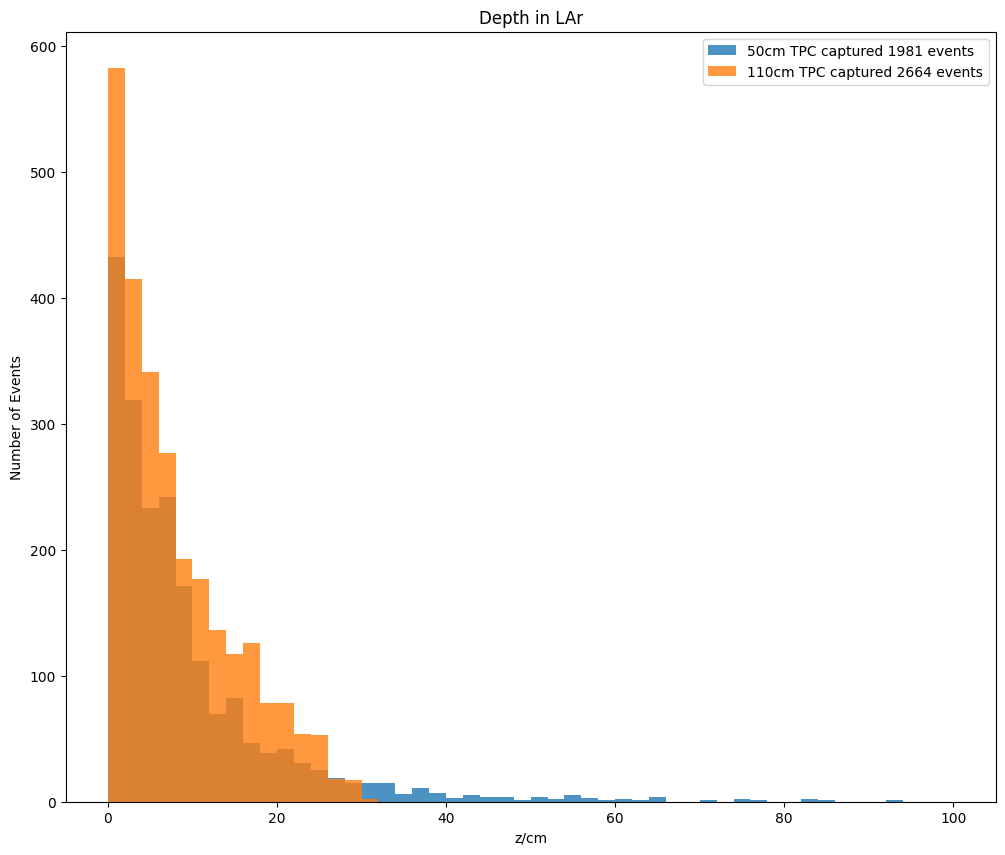

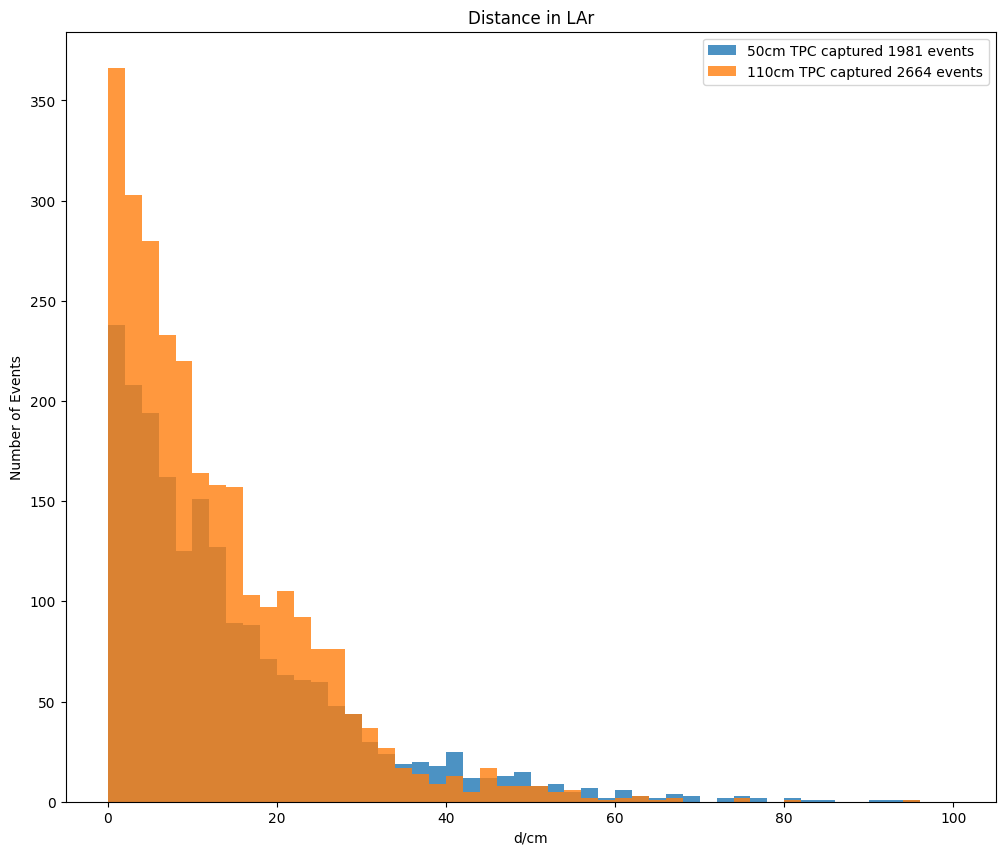

In [4]:
"""
This is for trace inside LArTPC study
"""

file_path_1 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_50cm.dat'
label_50cm= '50cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_1 = Analyze_trace(read_data_from_toymodel(file_path_1), -1000010020, stop_event=True, in_flight_event=False)

file_path_2 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e7_110cm.dat'
label_110cm= '110cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_2 = Analyze_trace(read_data_from_toymodel(file_path_2), -1000010020, stop_event=True, in_flight_event=False)

plt.figure(1, figsize=(12, 10))
plt.hist(trace_1[1], bins = 50, alpha = 0.8, label='50cm TPC captured '+ str(len(trace_1[1]))+' events', range=[0, 100])
plt.hist(trace_2[1], bins = 50, alpha = 0.8, label='110cm TPC captured '+ str(len(trace_2[1]))+' events', range=[0, 100])
plt.title("Depth in LAr")
plt.xlabel("z/cm")
plt.ylabel("Number of Events")
plt.legend()

plt.figure(2, figsize=(12, 10))
plt.hist(trace_1[2], bins = 50, alpha = 0.8, label='50cm TPC captured '+ str(len(trace_1[1]))+' events', range=[0, 100])
plt.hist(trace_2[2], bins = 50, alpha = 0.8, label='110cm TPC captured '+ str(len(trace_2[1]))+' events', range=[0, 100])
plt.title("Distance in LAr")
plt.xlabel("d/cm")
plt.ylabel("Number of Events")
plt.legend()

# For clear cache
trace_1 = None
trace_2 = None

Text(0.5, 1.0, '1e6 total events generated')

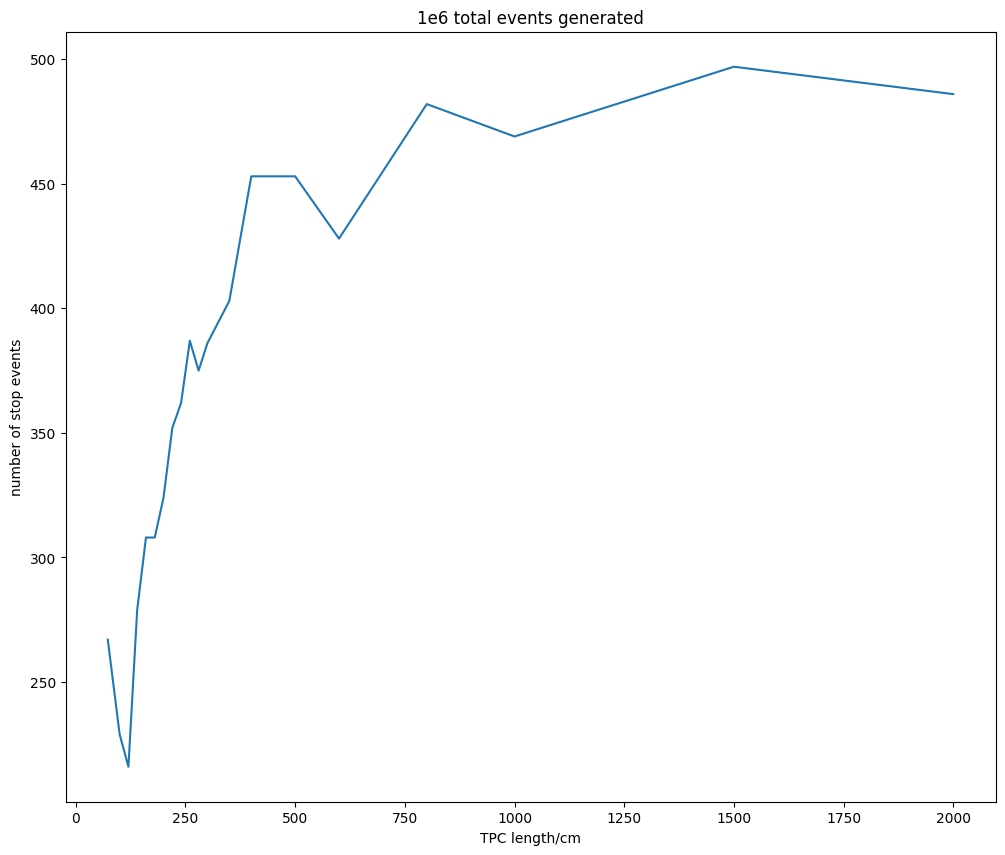

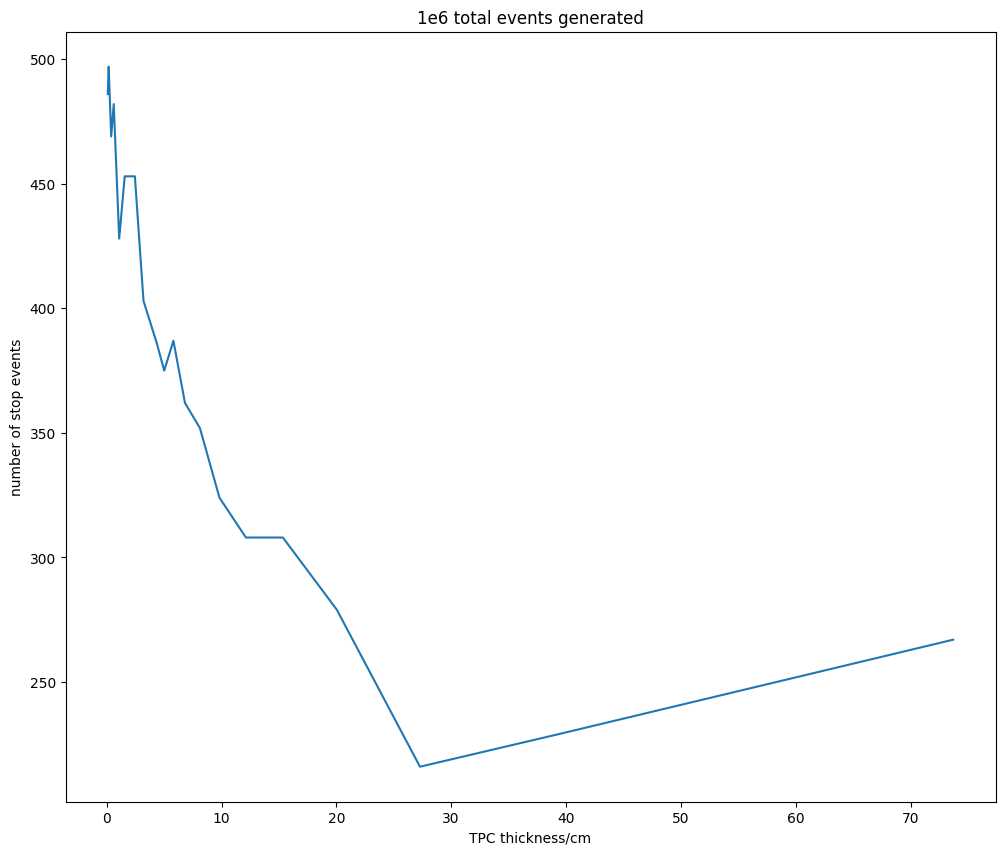

In [10]:
Stop_Events = [267, 229, 216, 279, 308, 308, 324, 352, 362, 387, 375, 386, 403, 453, 453, 428, 482, 469, 497, 486]
TPC_length = [73, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 350, 400, 500, 600, 800, 1000, 1500, 2000]

plt.figure(1, figsize=(12, 10))
plt.plot(TPC_length, Stop_Events)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("1e6 total events generated")

TPC_thickness = 550/1.4*1000/(np.array(TPC_length)**2)
plt.figure(2, figsize=(12, 10))
plt.plot(TPC_thickness, Stop_Events)
plt.xlabel("TPC thickness/cm")
plt.ylabel("number of stop events")
plt.title("1e6 total events generated")